# Preliminaries

In [1]:
import random
import os

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data_path = 'multiplex_embeddings_data'
datasets_layer_description = {  # {dataset: [layer_1 description, layer_2 description, ...]}
    'Air_Train': [
        'Air network',
        'Train network',
    ],
    'arXiv': [
        'physics.bioph category',
        'cond-mat.disnn category',
        'physics.soc-ph',
        'physics.data-an category',
        'math.OC category',
        'cond-mat.stat-mech category',
        'q-bio.MN category',
        'cs.SI category',
    ],
    'C. Elegans Connectomme': [
        'Electric',
        'Chemical Monadic',
        'Chemical Polyadic',
    ],
    'Drosophila Melanogaster': [  # meh
        'suppressive genetic interaction',
        'additive genetic interaction',
    ],
    'Human Brain': [
        'structural brain network',
        'functional brain network',
    ],
    'IPv4_IPv6 Internet': [  # meh
        'IPv4 topology',
        'IPv6 topology',
    ],
    'Physicians': [
        'advice',
        'discussion',
        'friendship',
    ],
    'Rattus': [  # meh
        'physical association',
        'direct interaction',
    ],
    'SacchPomb': [
        'direct interaction',
        'colocalization',
        'physical association',
        'synthetic genetic interaction',
        'association',
    ],
    'London_Multiplex_Transport': [
        'Tube (All underground lines aggregated)',
        'Overground',
        'DLR',
    ],
    'NYClimateMarch2014_Multiplex_Social': [
        'RT',
        'MT',
        'RE',
    ],
    'Cannes2013_Multiplex_Social': [
        'RT',
        'MT',
        'RE',
    ],
    'MoscowAthletics2013_Multiplex_Social': [
        'RT',
        'MT',
        'RE',
    ],
    'MLKing2013_Multiplex_Social': [
        'RT',
        'MT',
        'RE',
    ],
    'ObamaInIsrael2013_Multiplex_Social': [
        'RT',
        'MT',
        'RE',
    ],
    'CS-Aarhus_Multiplex_Social': [
        'lunch',
        'facebook',
        'coauthor',
        'leisure',
        'work',
    ],
    'Arabidopsis_Multiplex_Genetic': [
        'direct_interaction',
        'physical_association',
        'additive_genetic_interaction_defined_by_inequality',
        'suppressive_genetic_interaction_defined_by_inequality',
        'synthetic_genetic_interaction_defined_by_inequality',
        'association',
        'colocalization',
    ],
    'Bos_Multiplex_Genetic': [
        'physical_association',
        'association',
        'direct_interaction',
        'colocalization',
    ],
    'Celegans_Multiplex_Genetic': [
        'direct_interaction',
        'physical_association',
        'additive_genetic_interaction_defined_by_inequality',
        'suppressive_genetic_interaction_defined_by_inequality',
        'association',
        'colocalization',
    ],
    'Drosophila_Multiplex_Genetic': [
        'direct_interaction',
        'suppressive_genetic_interaction_defined_by_inequality',
        'additive_genetic_interaction_defined_by_inequality',
        'physical_association',
        'colocalization',
        'association',
        'synthetic_genetic_interaction_defined_by_inequality',
    ],
    'SacchCere_Multiplex_Genetic': [
        'physical_association',
        'suppressive_genetic_interaction_defined_by_inequality',
        'direct_interaction',
        'synthetic_genetic_interaction_defined_by_inequality',
        'association',
        'colocalization',
        'additive_genetic_interaction_defined_by_inequality',
    ],
    'YeastLandscape_Multiplex_Genetic': [
        'positive_interactions',
        'negative_interactions',
        'positive_correlations',
        'negative_correlations',
    ],
    'CovMulNet19': [
        'COVID19-GDDS332',
        'COVID19-GDDS457',
    ],
}
dataset_names = list(datasets_layer_description.keys())
datasets_layer_description, dataset_names

({'Air_Train': ['Air network', 'Train network'],
  'arXiv': ['physics.bioph category',
   'cond-mat.disnn category',
   'physics.soc-ph',
   'physics.data-an category',
   'math.OC category',
   'cond-mat.stat-mech category',
   'q-bio.MN category',
   'cs.SI category'],
  'C. Elegans Connectomme': ['Electric',
   'Chemical Monadic',
   'Chemical Polyadic'],
  'Drosophila Melanogaster': ['suppressive genetic interaction',
   'additive genetic interaction'],
  'Human Brain': ['structural brain network', 'functional brain network'],
  'IPv4_IPv6 Internet': ['IPv4 topology', 'IPv6 topology'],
  'Physicians': ['advice', 'discussion', 'friendship'],
  'Rattus': ['physical association', 'direct interaction'],
  'SacchPomb': ['direct interaction',
   'colocalization',
   'physical association',
   'synthetic genetic interaction',
   'association'],
  'London_Multiplex_Transport': ['Tube (All underground lines aggregated)',
   'Overground',
   'DLR'],
  'NYClimateMarch2014_Multiplex_Social': [

In [3]:
def random_relabel(G):
    nodes = list(G.nodes)
    random.shuffle(nodes)
    return nx.relabel_nodes(G, dict(zip(G.nodes, nodes)))

In [4]:
def find_component(node, connected_components):
    for i, component in enumerate(connected_components):
        if node in component:
            return i
    raise ValueError(f'Component for node {node} not found')

In [5]:
def cascade_remove_links(G):

    keep_going = True
    while keep_going:
        keep_going = False

        clusters_in_layers = [list(nx.connected_components(g)) for g in G]

        for i, g in enumerate(G):
            clusters_to_search = clusters_in_layers[:i] + clusters_in_layers[i + 1:]
            for edge in g.edges():
                if any(find_component(edge[0], clusters) != find_component(edge[1], clusters)
                       for clusters in clusters_to_search):
                    keep_going = True
                    g.remove_edge(*edge)
    
    return G

In [6]:
def articulation_points_multiplex(G):
    ap = set(nx.articulation_points(G[0]))
    return ap.union(*[nx.articulation_points(g) for g in G[1:]])

In [7]:
def max_comp(g):
    return max(nx.connected_components(g), key=len)

In [8]:
def remove_ap(G):
    G = cascade_remove_links(G)

    gcc = max_comp(G[0])
    gcc_size = len(gcc)

    for g in G:
        g.remove_nodes_from([n for n in g if n not in gcc])

    art_points = articulation_points_multiplex(G)

    for g in G:
        g.remove_nodes_from(art_points)

    return G, art_points, gcc_size

# Load dataset

In [9]:
len(dataset_names)

23

In [10]:
dataset_name = dataset_names[0]
random_relabeling = False

In [13]:
print(f'Loading {dataset_name}')
path = os.path.join(data_path, dataset_name)

if dataset_name == 'CovMulNet19':
    edges1 = pd.read_csv(os.path.join(
        path,
        f'{datasets_layer_description["CovMulNet19"][0]}-edges.csv',
    )).drop(columns='interaction_type')
    edges2 = pd.read_csv(os.path.join(
        path,
        f'{datasets_layer_description["CovMulNet19"][1]}-edges.csv',
    )).drop(columns='interaction_type')
    G_loaded = [nx.from_pandas_edgelist(edges1, source='V1', target='V2', create_using=nx.Graph),
                nx.from_pandas_edgelist(edges2, source='V1', target='V2', create_using=nx.Graph)]

else:
    layer_paths = [os.path.join(path, f'l_{i}.txt')
                    for i in range(1, len(datasets_layer_description[dataset_name]) + 1)]
    G_loaded = [nx.read_edgelist(
            layer_path,
            create_using=nx.Graph,
            nodetype=int,
        ) for layer_path in layer_paths]

if random_relabeling:
    for i, g in enumerate(G_loaded[1:]):
        G_loaded[i + 1] = random_relabel(g)
print(*G_loaded, sep='\n')

Loading CovMulNet19
Graph with 12658 nodes and 36441 edges
Graph with 17110 nodes and 57522 edges


## Preprocessing

In [14]:
G = [g for g in G_loaded if len(g) > 0]
# G = [g for g in G_loaded if len(g.edges) > 8000]
print(*G, sep='\n')

Graph with 12658 nodes and 36441 edges
Graph with 17110 nodes and 57522 edges


In [15]:
possible_nodes = set(G[0].nodes).union(
    *(set(g.nodes) for g in G[1:]),
)
real_nodes = possible_nodes.intersection(*(g.nodes for g in G))

print(f'Only {len(real_nodes)} real nodes that are present in all layers')

Only 12658 real nodes that are present in all layers


In [16]:
print(f'Dropping {len(possible_nodes) - len(real_nodes)} redundant nodes')
for g in G:
    g.remove_nodes_from([n for n in g if n not in real_nodes])

Dropping 4452 redundant nodes


Layer 1:
  Size: 12658
  Edges: 36441
  Mean degree: 5.757781640069521
Layer 2:
  Size: 12658
  Edges: 36441
  Mean degree: 5.757781640069521


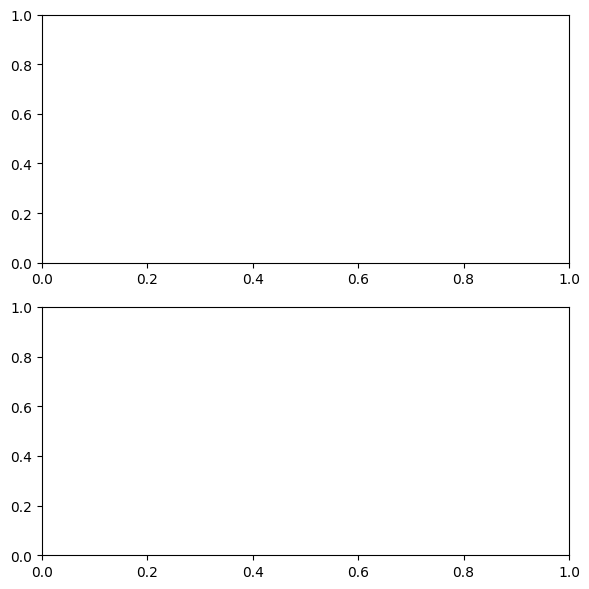

In [216]:
fig, ax = plt.subplots(nrows=len(G), ncols=1, figsize=(6, 3 * len(G)))
for i, g in enumerate(G):

    print(f'Layer {i + 1}:')
    print(f'  Size: {len(g)}')
    print(f'  Edges: {len(g.edges)}')

    degree_sequence = sorted((d for _, d in g.degree), reverse=True)
    print(f'  Mean degree: {np.mean(degree_sequence)}')

    # sorted_nodes = sorted(g.nodes)
    # mn, mx = sorted_nodes[0], sorted_nodes[-1]
    # if all(n1 == n2 for n1, n2 in zip(sorted_nodes, range(mn, mx + 1))):
    # # if sorted_nodes == list(range(mn, mx + 1)):
    #     print(f'  Nodes are labeled through {mn}:{mx}')
    # else:
    #     gaps = [n for n in range(mn, mx + 1) if n not in sorted_nodes]
    #     print(f'  Nodes are labeled through {mn}:{mx} with {len(gaps)} gaps {gaps}')
    
    # ax[i, 0].set_title('Degree distribution')
    # ax[i, 0].bar(*np.unique(degree_sequence, return_counts=True), width=.8)

    # ax[i, 1].set_title('Degree distribution (log)')
    # ax[i, 1].hist(degree_sequence, bins=np.logspace(np.log10(1), np.log10(len(g)), num=len(g)), rwidth=.8)
    # # ax[i, 1].hist(degree_sequence, bins=len(g), rwidth=.8)
    # ax[i, 1].set_xscale('log')
    # ax[i, 1].set_yscale('log')
    # # ax2.plot(np.exp(np.arange(1, np.log10(len(G)))), 1000 - 2.5 * np.exp(np.arange(1, np.log10(len(G)))))

    if len(g) < 1000:
        ax[i].set_title(f'Layer {i + 1}')
        # gcc = g.subgraph(sorted(nx.connected_components(g), key=len, reverse=True)[0])
        pos = nx.spring_layout(g)
        nx.draw_networkx_nodes(g, pos, ax=ax[i], node_size=20)
        ap = nx.articulation_points(g)
        nx.draw_networkx_nodes(g.subgraph(ap), pos, ax=ax[i], node_size=20, node_color='r')
        nx.draw_networkx_edges(g, pos, ax=ax[i], alpha=.4, arrows=True)
        ax[i].set_axis_off()

fig.tight_layout()

## Experiment

In [34]:
for i, g in enumerate(G):
    g = nx.relabel_nodes(g, dict(zip(G[0].nodes, range(len(G[0])))))
    nx.write_edgelist(g, f'cpp_data/l_{i + 1}.txt', data=False)

In [220]:
G, ap, gcc_size = remove_ap(G)
G, ap, len(ap), gcc_size

([<networkx.classes.graph.Graph at 0x23e169f2bc0>,
 set(),
 0,
 1)